In [1]:
!pip install numpy pandas scikit-learn opencv-python pydicom pyradiomics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 20.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Discarding https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz (from https://pypi.org/simple/pyradiomics/): Requested pyradiomics from https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz has inconsistent version: expected '3.1.0', but metadata has '3.0.1a1'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/

In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import pydicom
from radiomics import featureextractor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report


In [3]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gayathrishankar2905","key":"683dfedbc5fc742cbcd5e3494fb38c8c"}'}

In [4]:
!pip install kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"gayathrishankar2905","key":"683dfedbc5fc742cbcd5e3494fb38c8c"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset
!unzip breast-ultrasound-images-dataset.zip -d /content/breast_ultrasound_images


Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
License(s): CC0-1.0
Archive:  breast-ultrasound-images-dataset.zip
  inflating: /content/breast_ultrasound_images/Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: /content/breast_ultrasound_images/Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: /content/breast_ultrasound_images/Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: /content/breast_ultrasound_images/Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: /content/breast_ultrasound_images/Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: /content/breast_ultrasound_images/Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: /content/breast_ultrasound_images/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: /content/breast_ultrasound_images/Dataset_BUSI_with_GT/benign/benign (101).png  
  inflating: /content/breast_ultrasound_images/Dataset_BUSI_with_GT/benign/b

In [5]:
import os

dataset_path = "/content/breast_ultrasound_images/Dataset_BUSI_with_GT"
categories = ["benign", "malignant", "normal"]

for category in categories:
    folder_path = os.path.join(dataset_path, category)
    if os.path.exists(folder_path):
        print(f"Found {len(os.listdir(folder_path))} images in '{category}' category.")


Found 891 images in 'benign' category.
Found 421 images in 'malignant' category.
Found 266 images in 'normal' category.


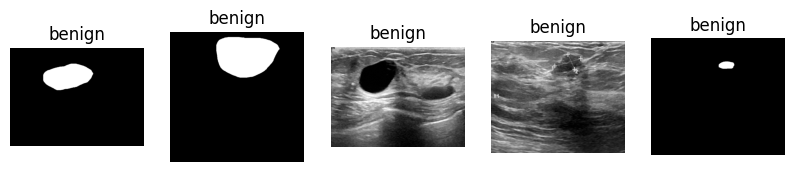

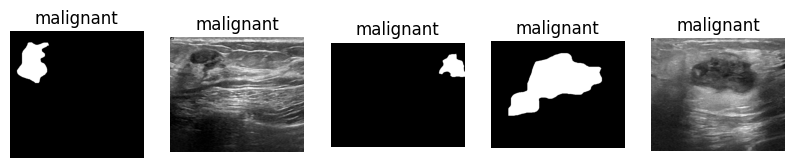

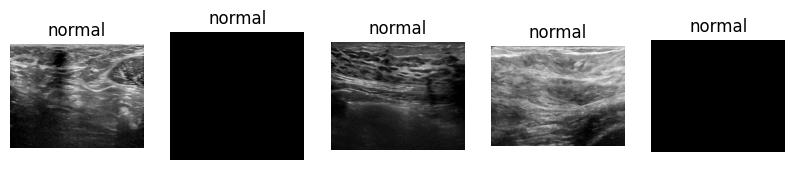

In [6]:
import cv2
import matplotlib.pyplot as plt

def show_sample_images(category):
    folder = os.path.join(dataset_path, category)
    images = os.listdir(folder)[:5]  # Show first 5 images

    plt.figure(figsize=(10,5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, 5, i+1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(category)
    plt.show()

# Show sample images from each category
for cat in categories:
    show_sample_images(cat)


In [7]:
import shutil

# Create a new directory structure
data_dir = "/content/dataset_radiomics"
os.makedirs(data_dir, exist_ok=True)

for category in categories:
    src_folder = os.path.join(dataset_path, category)
    dest_folder = os.path.join(data_dir, category)
    os.makedirs(dest_folder, exist_ok=True)

    for file_name in os.listdir(src_folder):
        src_path = os.path.join(src_folder, file_name)
        dest_path = os.path.join(dest_folder, file_name)
        shutil.copy(src_path, dest_path)

print("Dataset is now ready for radiomics feature extraction.")


Dataset is now ready for radiomics feature extraction.


In [8]:
import os
import glob

dataset_path = "/content/breast_ultrasound_images/Dataset_BUSI_with_GT"
categories = ["benign", "malignant", "normal"]

image_paths = []
mask_paths = []

for category in categories:
    folder_path = os.path.join(dataset_path, category)

    if os.path.exists(folder_path):
        images = sorted(glob.glob(os.path.join(folder_path, "*.png")))  # Load all PNG files
        for img_path in images:
            if "_mask" not in img_path:  # Ignore mask files
                mask_path = img_path.replace(".png", "_mask.png")  # Find corresponding mask
                if os.path.exists(mask_path):  # Ensure mask exists
                    image_paths.append(img_path)
                    mask_paths.append(mask_path)

print(f"Total images: {len(image_paths)}, Total masks: {len(mask_paths)}")


Total images: 780, Total masks: 780


In [9]:
from sklearn.model_selection import train_test_split

train_images, val_images, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

print(f"Training set: {len(train_images)} images, Validation set: {len(val_images)} images")


Training set: 624 images, Validation set: 156 images


In [10]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images & masks
    transforms.ToTensor(),  # Convert to tensor
])


In [11]:
from torch.utils.data import Dataset
from PIL import Image

class BreastTumorDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")  # Convert to grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


In [12]:
from torch.utils.data import DataLoader

train_dataset = BreastTumorDataset(train_images, train_masks, transform=transform)
val_dataset = BreastTumorDataset(val_images, val_masks, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [13]:
import torch
import torchvision.models.segmentation as models

# Load DeepLabV3+ with ResNet-101 backbone (pretrained on COCO)
model = models.deeplabv3_resnet101(pretrained=True)

# Modify the final classifier to match our dataset (1 class + background = 2 output channels)
model.classifier[4] = torch.nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("Model Loaded Successfully")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 172MB/s]


Model Loaded Successfully


In [14]:
import torch.optim as optim

# Define loss function
criterion = torch.nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)['out']  # Get model predictions

            # Convert masks to LongTensor (required for CrossEntropyLoss)
            masks = masks.squeeze(1).long()

            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    print("Training Complete")


In [16]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


Epoch [1/10], Loss: 0.4607
Epoch [2/10], Loss: 0.2076
Epoch [3/10], Loss: 0.1348
Epoch [4/10], Loss: 0.1013
Epoch [5/10], Loss: 0.0720
Epoch [6/10], Loss: 0.0595
Epoch [7/10], Loss: 0.0503
Epoch [8/10], Loss: 0.0418
Epoch [9/10], Loss: 0.0356
Epoch [10/10], Loss: 0.0615
Training Complete


In [17]:
torch.save(model.state_dict(), "deeplabv3_breast_ultrasound.pth")
print("Model saved successfully!")


Model saved successfully!


In [18]:
model.eval()  # Set model to evaluation mode


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [19]:
import torch.nn.functional as F

def compute_iou(pred_mask, true_mask):
    intersection = torch.logical_and(pred_mask, true_mask).sum().item()
    union = torch.logical_or(pred_mask, true_mask).sum().item()
    return intersection / union if union != 0 else 0

def evaluate_model(model, val_loader):
    model.eval()  # Set to eval mode
    iou_scores = []

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)['out']
            predicted_masks = torch.argmax(outputs, dim=1)  # Get class with max probability

            for i in range(len(images)):
                iou = compute_iou(predicted_masks[i], masks[i])
                iou_scores.append(iou)

    avg_iou = sum(iou_scores) / len(iou_scores)
    print(f"Average IoU Score: {avg_iou:.4f}")

# Run evaluation
evaluate_model(model, val_loader)


Average IoU Score: 0.4066


In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Load a test image
test_image_path = "/content/breast_ultrasound_images/Dataset_BUSI_with_GT/benign/benign (1).png"
image = Image.open(test_image_path).convert("RGB")

# Apply same transformations as training
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

# Perform inference
model.eval()
with torch.no_grad():
    output = model(image_tensor)['out']

# Convert prediction to mask
pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

# Display the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Segmentation Mask")
plt.show()
